In [7]:
import itertools

import yaml
import pandas as pd
import numpy as np
import sklearn.metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import lab.metrics
import lab.analytics

In [8]:
def load_results():
    combinations = [
        (classifier, defence, mode, suffix)
        for classifier in ["kfp", "dfnet"]
        for defence in ["tamaraw", ]
        for mode in ["delay.300mult-unmon"]
        for suffix in ["", ".sim", "-filtered"]
    ]
        
    return (pd.concat([
        pd.read_csv(f"../../results/delay-vs-drop/{defence}/{mode}/predict{suffix}/{classifier}-0.csv", header=0)
        for (classifier, defence, mode, suffix) in combinations
    ], keys=combinations, names=["classifier", "defence", "mode", "suffix"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
           )#.drop(columns=[-1]))


data = load_results()
data

y_true        -1  \
classifier defence mode                suffix                            
kfp        tamaraw delay.300mult-unmon           0      -1.0  1.000000   
                                                 1      -1.0  1.000000   
                                                 2      -1.0  1.000000   
                                                 3      -1.0  1.000000   
                                                 4      -1.0  1.000000   
...                                                      ...       ...   
dfnet      tamaraw delay.300mult-unmon -filtered 215     0.0  0.000002   
                                                 216     0.0  0.000005   
                                                 217     0.0  0.000049   
                                                 218     0.0  0.000003   
                                                 219     0.0  0.000004   

                                                             0  
classifier defence mode                suffix                   
kfp        tamaraw delay.300mult-unmon           0    0.000000  
                                                 1    0.000000  
                                                 2    0.000000  
                                                 3    0.000000  
                                                 4    0.000000  
...                                                        ...  
dfnet      tamaraw delay.300mult-unmon -filtered 215  0.999998  
                                                 216  0.999995  
                                                 217  0.999951  
                                                 218  0.999997  
                                                 219  0.999996  

[1320 rows x 3 columns]

In [9]:
data["y_pred"] = data.drop(columns="y_true").idxmax(axis=1)
data
data.groupby(["classifier", "suffix"]).apply(lambda data: sklearn.metrics.balanced_accuracy_score(data["y_true"], data["y_pred"]))

classifier  suffix   
dfnet                    0.6000
            -filtered    0.9625
            .sim         0.6900
kfp                      0.8000
            -filtered    0.8500
            .sim         0.4375
dtype: float64

In [10]:
plot_data = data.groupby(["classifier", "suffix"]).apply(lambda x: pd.DataFrame(dict(zip(["precision", "recall"], sklearn.metrics.precision_recall_curve(x["y_true"], x.loc[:, 0], pos_label=0))))).reset_index()
plot_data

,classifier,suffix,level_2,precision,recall
0,dfnet,,0,0.606061,1.00
1,dfnet,,1,0.593750,0.95
2,dfnet,,2,0.612903,0.95
3,dfnet,,3,0.633333,0.95
4,dfnet,,4,0.655172,0.95
...,...,...,...,...,...
76,kfp,-filtered,4,1.000000,0.00
77,kfp,.sim,0,0.090909,1.00
78,kfp,.sim,1,0.214286,0.60
79,kfp,.sim,2,0.000000,0.00


In [11]:
plot_data["suffix"] = plot_data["suffix"].replace({".sim": "simulated", "": "collected", "-filtered": "filtered"})
plot_data.columns = ["dataset" if x == "suffix" else x for x in plot_data.columns]

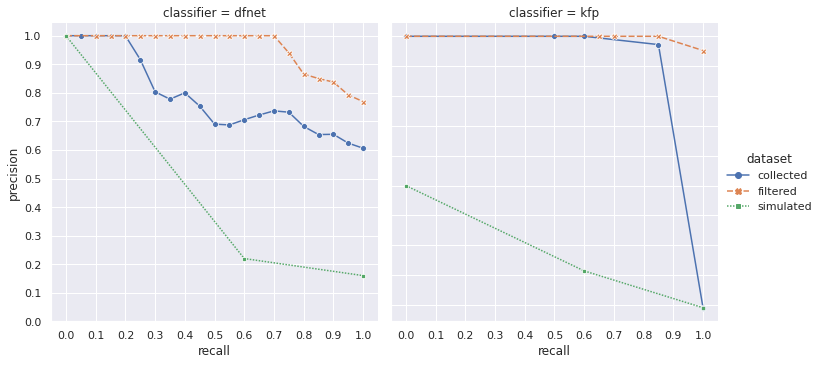

In [26]:
sns.set()
fig = sns.relplot(data=plot_data, x="recall", y="precision", hue="dataset", col="classifier", kind="line", ci=None, markers=True, style="dataset")
fig.axes[0][0].set_xticks(np.arange(0, 1.1, .1))
fig.axes[0][0].set_yticks(np.arange(0, 1.1, .1))

fig.savefig("/tmp/open-world.jpg", bbox_inches="tight")